<a href="https://colab.research.google.com/github/An-Dongsun/Melanoma-Detection/blob/feature%2FDL_model/DL_model_%EC%A0%9C%EC%9E%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 흑색종 이미지 분류 모델

- 지루성 각화증 → 387개
- 모반 → 8,570개
- 흑색종(양성) → 5,515개
- 흑색종(악성) → 5,119개
- 기저 세포 암종(BCC) → 516개

In [51]:
# 필요할 라이브러리 불러오기
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

# 전이학습 모델
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import EfficientNetB7, EfficientNetV2M, EfficientNetV2S


# 분류기 제작
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model, Sequential, load_model

# 1. 데이터 불러오기

In [2]:
# 시드를 고정한다.
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
# 이미지 파일들 불러오기
Dataset_directory = '/content/drive/MyDrive/CP1 데이터'

train = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory,
        labels = "inferred",
        label_mode = 'categorical', # 레이블이 범주형 벡터로 인코딩됨을 의미
        class_names = {'BCC(기저 세포 암종)', 'benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)'},
        color_mode = "rgb",
        batch_size = 64,
        image_size = (256, 256),
        shuffle = True,
        seed = 42,
        validation_split = 0.1,
        subset = 'training',
        interpolation = "bilinear",
        follow_links = False,
        crop_to_aspect_ratio = False,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory,
        labels = "inferred",
        label_mode = 'categorical',
        class_names = {'BCC(기저 세포 암종)', 'benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)'},
        color_mode = "rgb",
        batch_size = 64,
        image_size = (256, 256),
        shuffle = True,
        seed = 42,
        validation_split = 0.1,
        subset = 'validation',
        interpolation = "bilinear",
        follow_links = False,
        crop_to_aspect_ratio = False,
)

Found 20053 files belonging to 5 classes.
Using 18048 files for training.
Found 20053 files belonging to 5 classes.
Using 2005 files for validation.


# Restnet50 전이학습


In [4]:
resnet = ResNet50(weights = 'imagenet', include_top = False)

In [5]:
# ResNet50 레이어들의 파라미터를 학습하도록 설정
for layer in resnet.layers:
    layer.trainable = True

In [6]:
# 모델에 출력층을 생성해준다.
x = resnet.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) # 출력층을 설계한다.
resnet_model = Model(resnet.input, predictions)

In [ ]:
# 모델의 전체적인 형태 확인해보기
resnet_model.summary()

In [8]:
# 모델 컴파일
resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [9]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath = "resnet_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 128
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results = resnet_model.fit(train,
                            batch_size = batch_size,
                            epochs = epochs_max,
                            verbose = 1, 
                            validation_data = test,
                            callbacks = [early_stop, save_best])

Epoch 1/50
141/141 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8719
Epoch 1: val_loss improved from inf to 5.23827, saving model to resnet_model_best.hdf5
141/141 [==============================] - 286s 2s/step - loss: 0.3634 - accuracy: 0.8719 - val_loss: 5.2383 - val_accuracy: 0.3830
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.9172
Epoch 2: val_loss did not improve from 5.23827
141/141 [==============================] - 280s 2s/step - loss: 0.2057 - accuracy: 0.9172 - val_loss: 15.5683 - val_accuracy: 0.5860
Epoch 3/50
141/141 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.9252
Epoch 3: val_loss improved from 5.23827 to 3.21583, saving model to resnet_model_best.hdf5
141/141 [==============================] - 286s 2s/step - loss: 0.1980 - accuracy: 0.9252 - val_loss: 3.2158 - val_accuracy: 0.4279
Epoch 4/50
141/141 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0

## 학습된 모델을 이용하여 테스트 & 저장

In [11]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = resnet_model.evaluate(test, verbose = 1)

16/16 [==============================] - 26s 769ms/step - loss: 0.3472 - accuracy: 0.8883


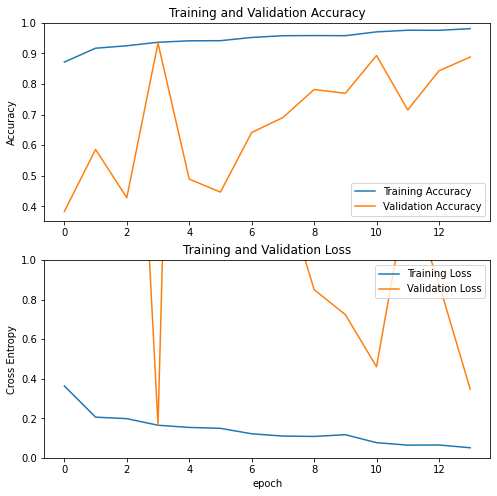

In [12]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
# 최고의 성능을 내는 파라미터를 불러온다.
resnet_model.load_weights(checkpoint_filepath)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = resnet_model.evaluate(test, verbose = 1)

16/16 [==============================] - 27s 775ms/step - loss: 0.1650 - accuracy: 0.9342


In [14]:
# Model 저장
resnet_model.save('resnet_base_model.h5')

# InceptionResNetV2 이용한 전이학습

In [22]:
inception_resnet = tf.keras.applications.InceptionResNetV2(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              )

In [23]:
# InceptionResNetV2 레이어들의 파라미터를 새로운 데이터에 맞게 학습하도록 설정
for layer in inception_resnet.layers:
    layer.trainable = True

In [24]:
# 모델에 출력층을 생성해준다.
x = inception_resnet.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) # 출력층을 설계한다.
inception_resnet_model = Model(inception_resnet.input, predictions)

In [ ]:
inception_resnet_model.summary()

In [26]:
# 모델 컴파일
inception_resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## OOM 때문에 batch size를 64로 줄였다.

In [29]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath2 = "inception_resnet_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath2,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 64
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results2 = inception_resnet_model.fit(train,
                                      batch_size = batch_size,
                                      epochs = epochs_max,
                                      verbose = 1,
                                      validation_data = test,
                                      callbacks = [early_stop, save_best])

Epoch 1/50
282/282 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.8974
Epoch 1: val_loss improved from inf to 0.22112, saving model to inception_resnet_model_best.hdf5
282/282 [==============================] - 313s 1s/step - loss: 0.2870 - accuracy: 0.8974 - val_loss: 0.2211 - val_accuracy: 0.9037
Epoch 2/50
282/282 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9245
Epoch 2: val_loss did not improve from 0.22112
282/282 [==============================] - 293s 1s/step - loss: 0.1917 - accuracy: 0.9245 - val_loss: 0.3445 - val_accuracy: 0.8788
Epoch 3/50
282/282 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9306
Epoch 3: val_loss did not improve from 0.22112
282/282 [==============================] - 293s 1s/step - loss: 0.1785 - accuracy: 0.9306 - val_loss: 0.2268 - val_accuracy: 0.9247
Epoch 4/50
282/282 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9432
Epoch 4: val_loss did not imp

In [30]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = inception_resnet_model.evaluate(test, verbose = 1)

32/32 [==============================] - 27s 577ms/step - loss: 0.2028 - accuracy: 0.9451


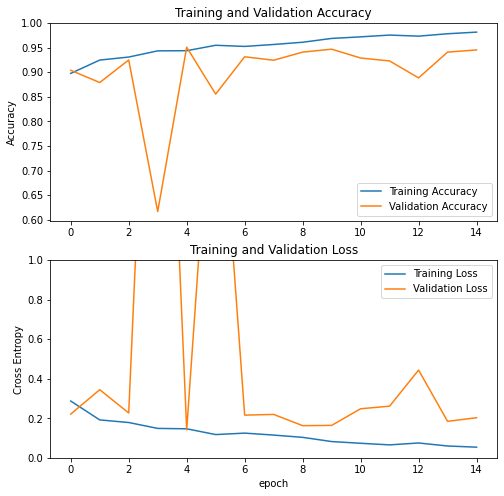

In [34]:
acc = results2.history['accuracy']
val_acc = results2.history['val_accuracy']

loss = results2.history['loss']
val_loss = results2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
inception_resnet_model.load_weights(checkpoint_filepath2)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = inception_resnet_model.evaluate(test, verbose = 1)

32/32 [==============================] - 27s 576ms/step - loss: 0.1412 - accuracy: 0.9506


In [33]:
# Model 저장
inception_resnet_model.save('inception_resnet_model.h5')

# EfficientNetV2M

In [36]:
EfficientNet_V2M = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
                   include_top = False,
                   weights = 'imagenet',
                   input_tensor = None,
                   input_shape = (256, 256, 3)
                   )

214212608/214201816 [==============================] - 1s 0us/step


In [37]:
# EfficientNetV2M 레이어들의 파라미터를 새로운 데이터에 맞게 학습하도록 설정
for layer in EfficientNet_V2M.layers:
    layer.trainable = True

In [38]:
# 모델에 출력층을 생성해준다.
x = EfficientNet_V2M.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) # 출력층을 설계한다.
EfficientNet_V2M_model = Model(EfficientNet_V2M.input, predictions)

In [39]:
EfficientNet_V2M_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                            

In [40]:
# 모델 컴파일
EfficientNet_V2M_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## OOM 때문에 batch size를 32로 줄였다.

In [42]:
# 이미지 파일들 불러오기
Dataset_directory = '/content/drive/MyDrive/CP1 데이터'

train = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory,
        labels = "inferred",
        label_mode = 'categorical', # 레이블이 범주형 벡터로 인코딩됨을 의미
        class_names = {'BCC(기저 세포 암종)', 'benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)'},
        color_mode = "rgb",
        batch_size = 32,
        image_size = (256, 256),
        shuffle = True,
        seed = 42,
        validation_split = 0.1,
        subset = 'training',
        interpolation = "bilinear",
        follow_links = False,
        crop_to_aspect_ratio = False,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory,
        labels = "inferred",
        label_mode = 'categorical',
        class_names = {'BCC(기저 세포 암종)', 'benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)'},
        color_mode = "rgb",
        batch_size = 32,
        image_size = (256, 256),
        shuffle = True,
        seed = 42,
        validation_split = 0.1,
        subset = 'validation',
        interpolation = "bilinear",
        follow_links = False,
        crop_to_aspect_ratio = False,
)

Found 20053 files belonging to 5 classes.
Using 18048 files for training.
Found 20053 files belonging to 5 classes.
Using 2005 files for validation.


In [45]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath3 = "EfficientNet_V2M_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath3,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results3 = EfficientNet_V2M_model.fit(train,
                                      batch_size = batch_size,
                                      epochs = epochs_max,
                                      verbose = 1,
                                      validation_data = test,
                                      callbacks = [early_stop, save_best])

Epoch 1/50
564/564 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9167
Epoch 1: val_loss improved from inf to 0.25979, saving model to EfficientNet_V2M_model_best.hdf5
564/564 [==============================] - 350s 615ms/step - loss: 0.2224 - accuracy: 0.9167 - val_loss: 0.2598 - val_accuracy: 0.8913
Epoch 2/50
564/564 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9308
Epoch 2: val_loss improved from 0.25979 to 0.19290, saving model to EfficientNet_V2M_model_best.hdf5
564/564 [==============================] - 350s 613ms/step - loss: 0.1841 - accuracy: 0.9308 - val_loss: 0.1929 - val_accuracy: 0.9347
Epoch 3/50
564/564 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9328
Epoch 3: val_loss improved from 0.19290 to 0.16663, saving model to EfficientNet_V2M_model_best.hdf5
564/564 [==============================] - 350s 614ms/step - loss: 0.1769 - accuracy: 0.9328 - val_loss: 0.1666 - val_accuracy: 0.9332
Epoch 4/

In [46]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = EfficientNet_V2M_model.evaluate(test, verbose = 1)

63/63 [==============================] - 26s 352ms/step - loss: 0.2748 - accuracy: 0.9466


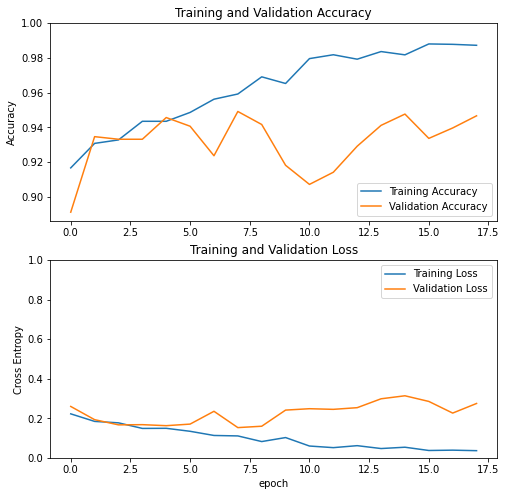

In [47]:
acc = results3.history['accuracy']
val_acc = results3.history['val_accuracy']

loss = results3.history['loss']
val_loss = results3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
EfficientNet_V2M_model.load_weights(checkpoint_filepath3)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = EfficientNet_V2M_model.evaluate(test, verbose = 1)

63/63 [==============================] - 27s 353ms/step - loss: 0.1527 - accuracy: 0.9491


In [49]:
# Model 저장
inception_resnet_model.save('EfficientNet_V2M_model.h5')